In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#from matplotlib.animation import FuncAnimation
#from celluloid import Camera
import matplotlib.cm as cm
from scipy.sparse import diags
#from scipy.sparse.linalg import eigsh
#import scipy
plt.rcParams.update({'font.size': 14})

In this notebook the diffusion equation/heat equation is solved implicit and explicit.

## $$
\frac{\partial u}{\partial t}=   \alpha \frac{\partial^2 u}{\partial x^2} 
$$

Initial parameters:

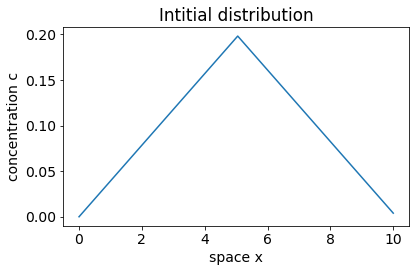

In [3]:
Nx = 100                     #x steps
Nt = 2000                    #t steps
L = 10                       #Length of the domain ([0,L])
T = 10                        #Stop time of the simulation
#Remark T should be smaller Nt/200 to get resonable results for the explicit method
# F < 1/2
D = 1                        #Diffusion coefficient

x = np.linspace(0, L, Nx)    #x space   
t = np.linspace(0, T, Nt)    #t space
dt = t[1]-t[0]               #t step
dx = x[1] - x[0]             #x step
F = D * dt/dx**2

#Creates a triangle function as initial distribution
def initf(x,Nx):
    mini = 1
    maxi = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = -(mini-maxi)/int(Nx/2)*i
        ini[i+int(Nx/2)] = (mini-maxi)/int(Nx/2)*i+mini
    ini /= sum(ini)*dx
    return ini#

def plotresult(x,c,Darray,title):
    colorwave = cm.plasma(np.linspace(0, 1, Nt))
    fig=plt.figure(1, figsize = (15,5) )
    host = plt.subplot(1,2,1)
    par1 = host.twinx()
    color1 = 'orange'
    color2 = 'blue'
    host.set_xlabel('space x')
    host.set_ylabel('initial concentration', color=color1)
    par1.set_ylabel('Diffusion coefficient', color=color2)
    host.tick_params('y', colors=color1)
    par1.tick_params('y', colors=color2)
    p1 = host.plot(x,c[:,0],color=color1)
    p2 = par1.plot(x,Darray,color=color2)
    plt.title('Initial conditions')
    
    ax2 = plt.subplot(1,2,2)
    for i in range(Nt):
        if i % 100 == 0:
            plt.plot(x,c[:,i],c=colorwave[i])
            plt.xlabel('space x')
            plt.ylabel('concentration c')
            plt.title(str(title))
    plt.title('Time evolution')
    plt.tight_layout()  
    plt.savefig(str(title)+'.svg', format='svg')
    plt.show()

binitial = initf(x,Nx)              #initial distribution         

plt.plot(x,binitial)           #Plot the initial distribution
plt.title('Intitial distribution')
plt.xlabel('space x')
plt.ylabel('concentration c')
plt.tight_layout()  
plt.show()

# Explicit method - Forward Euler scheme
http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html#forward-euler-scheme

Space and time are descretized into:

### $x_{i}=i \Delta x, \: \: \: i = 0,...,N_x$
### $t_{n}=n \Delta t, \: \: \: n = 0,...,N_t$.

$u_i^n$ denotes the mesh function that approximates $u(x_i,t_n)$. The diffusion equation now needs to be fulfilled at every mesh point $(x_i,t_n)$. This leads to the equation:

### $\frac{\partial }{\partial t} u\left ( x_{i},t_{n} \right ) = \alpha \frac{\partial^2 }{\partial x^2} u\left ( x_{i},t_{n} \right )$.

The derivatives are now replaced by finite difference approximations. The simplest method is to use forward difference in time and a central difference in space (which is equivalent to first perform forward difference and than backward difference in space):

----------------------
Remark: Derivation of $D_{x}^{-} D_{x}^{+}u$: 

### $D_{x}^{-} D_{x}^{+}u_{i}^{n} = D_{x}^{-} \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x}=\frac{u_{i+1}^{n}-u_{i}^{n}-u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}} =\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}$
-------------


### $\left [ D^{+}_{t}u=\alpha D_{x}^{-} D_{x}^{+}u \right ]^{n}_{i}$.

This can be written as:

### $\frac{u^{n+1}_{i}-u^{n}_{i}}{\Delta t} = \alpha \frac{u^{n}_{i-1}-2u^{n}_{i}+u^{n}_{i-1}}{\Delta x^2}$

and than rearranged for $u^{n+1}_{i}$:

### $u^{n+1}_{i}=u^{n}_{i}+F\left ( u^{n}_{i+1}-2u^{n}_{i}+u^{n}_{i-1} \right )$,

where $F = \frac{\alpha \Delta t}{\Delta x^2}$. With that formula, the diffusion equation can be solved stepwise.

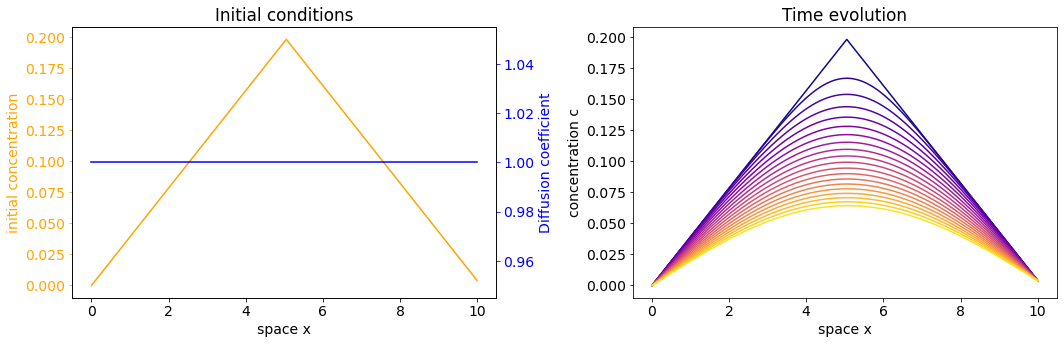

In [4]:
c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = binitial

for n in range(Nt-1):
    for i in range(1,Nx-1):
        c[i,n+1] = c[i,n] + F*(c[i+1,n]-2*c[i,n]+c[i-1,n])
    c[0,n+1] =  c[0,0]#c[1,n+1]#
    c[-1,n+1] =  c[-1,0]#c[-2,n+1]#
    
Darray = D*np.ones(Nx)
plotresult(x,c,Darray,'Explicit Solution')

# Implicit method - Backward Euler scheme
http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html#backward-euler-scheme

Here the backward difference in time is and the central difference in space is applied:

###  $\left [ D^{-}_{t}u=\alpha D_{x}^{+} D_{x}^{-}u \right ]^{n}_{i}$

which can be written as:
###  $\frac{u^{n}_{i}-u^{n-1}_{i}}{\Delta t} = \alpha \frac{u^{n}_{i-1}-2u^{n}_{i}+u^{n}_{i-1}}{\Delta x^2}$.

Now assume that $u^{n-1}_{i}$ is computed, but all other quantities are unknown ($u^{n}_{i}$ is in the future). Let us now the equations for the case that $N_{x} = 3$:

###  $\frac{u^{n}_{1}-u^{n-1}_{1}}{\Delta t} = \alpha \frac{u^{n}_{0}-2u^{n}_{1}+u^{n}_{2}}{\Delta x^2}$
###  $\frac{u^{n}_{2}-u^{n-1}_{2}}{\Delta t} = \alpha \frac{u^{n}_{1}-2u^{n}_{2}+u^{n}_{3}}{\Delta x^2}$

The boundary values $u_{0}^{n}$ and $u_{3}^{n}$ are known to be zero. We can now rearrange the equations for $u_{1}^{n-1}$ and $u_{2}^{n-1}$

### $(1+2F)u^{n}_{1} - F u^{n}_{2}=u^{n-1}_{1}$
### $-F u^{n}_{1} + (1+2F)u^{n}_{2}=u^{n-1}_{2}$

This is a coupled $2 \times  2$ system of algebraic equations for the unknown $u_{1}$ and $u_{2}^{n}$. The equivalent matrix form is:

###  $\begin{pmatrix}
1+2F & -F\\ 
-F & 1+2F
\end{pmatrix}
\binom{u_{1}^{n}}{u_{2}^{n}} =
\binom{u_{1}^{n-1}}{u_{2}^{n-1}}$

In the genral case, we now have a system of $(Nx-1) \times  (Nx-1)$ coupled equations for all the unknown $u_{i}^{n}$. Collecting the unkonwns on the left-hand side it can be written as:

###  $-Fu^{n}_{i-1+}(1+2F)u^{n}_{i} - F u^{n}_{i+2}=u^{n-1}_{i-1}$

A coupled system of algebraic equations can be written on matrix form as $MU=b$, where $U=\left ( u^{n}_{0}, \cdots ,u^{n}_{N_{x}} \right )$. For solving the ODE we need to include the boundary conditions: $u_{0}^{n} = 0$ and $u_{N_{x}}^{n} = 0$. Those initial conditions are introduced by setting $M_{0,0}=M_{N_{x},N_{x}}=1$ and $M_{0,1}=M_{N_{x},N_{x-1}}=0$. The vector b equals $b_{i}=u_{i}^{n-1}$ but with the initial conditions $b_{0}=b_{N_{x}}=0$. 

The final matrix to solve is for example in the case $ 6 \times 6$ than:

###  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -F & 1+ 2\cdot F  & -F & 0 & 0 & 0\\
 0 & -F  & 1+ 2\cdot F & -F & 0 & 0\\
 0 & 0  & -F  & 1+ 2\cdot F & -F & 0\\
 0 & 0  & 0  &  -F & 1+ 2\cdot F & -F\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
0\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
0
\end{bmatrix}
$

The matrix $M$ contains quantities that do not change in time. Therefore $M$ can be formed once and for all. The right hand side $b$ must be updated at each time step.

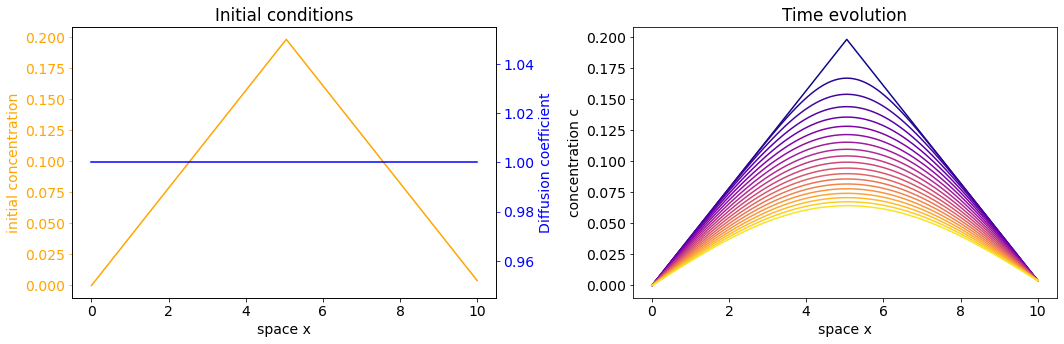

In [5]:
#Create the matrix to solve the ODE
#http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html#sparse-matrix-implementation

M = (F*diags([-1, 2, -1], [-1,0, 1], shape=(Nx, Nx))+diags([1], [0], shape=(Nx, Nx))).todense()
M[0,1] = M[-1,-2] = 0
M[0,0] = M[-1,-1]= 1
#print(M)

c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = binitial

for i in range(1,Nt):
    b = c[:,i-1]
    csingle = np.linalg.solve(M,b)
    c[:,i] = csingle#/sum(abs(csingle)*dx)
 
Darray = D*np.ones(Nx)
plotresult(x,c,Darray,'Explicit Solution')

# Idea to solve our equation

### $
\frac{\partial u}{\partial t}=  \frac{\partial }{\partial x} \left (\alpha \left ( x \right ) \frac{\partial u}{\partial x}   \right )
$

My idea to solve this equation is to transfer it to the following form:

### $\left [ D_{t}^{-}u=D_{x}^{-}\alpha D_{x}^{+}u \right ]^{n}_{i}$

Performe the first forward derivative on $u$ on the right side (and also the backward derivative in time on the left side):

### $\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} = D^{-}\alpha  \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x}$.

Next step is to performe the first backward derivative on $\alpha$ and the first derivative of $u$. I use thte procut rule ($h\left ( x \right ) = f\left ( x \right ) \cdot g\left ( x \right )$; ${h}'\left ( x \right ) = {f}'\left ( x \right ) \cdot g\left ( x \right ) + f\left ( x \right ) \cdot {g}'\left ( x \right )$):

### $\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} = \frac{\alpha_{i}-\alpha _{i-1}}{\Delta x}\cdot \frac{u_{i+1}^{n}-u^{n}_{i}}{\Delta x} + \alpha _{i}\cdot \frac{u^{n}_{i+1}-2u^{n}_{i}+u_{i-1}^{n}}{\Delta x^{2}}$

Rearrange for $-u_{i}^{n}$ and use the abbreviation $G = \frac{\Delta t}{\Delta x^{2}}$:
### $-u_{i}^{n-1}=-u_{i}^{n}+G\left ( \alpha _{i}u_{i+1}^{n}-\alpha _{i}u_{i}^{n}-\alpha _{i-1}u_{i+1}^{n}+\alpha _{i-1}u_{i}^{n}+\alpha _{i}u^{n}_{i+1}-2\alpha_{i}u_{i}^{n}+\alpha _{i}u_{i-1}^{n} \right )$

Multiply with -1 and reange the terms:
### $u_{i}^{n-1}= u_{i}^{n} \left [ 1+G\left ( \alpha _{i}-\alpha _{i-1}+2\alpha _{i} \right ) \right ]  - u_{i-1}^{n}G\alpha _{i}
+u^{n}_{i+1}G\left ( -\alpha _{i}+\alpha _{i-1}-\alpha _{i} \right )$

Simplify:
### $u_{i}^{n-1}= u_{i}^{n} \left [ 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) \right ]  - u_{i-1}^{n}G\alpha _{i}
+u^{n}_{i+1}G\left ( \alpha _{i-1}-2\alpha _{i} \right ).
$

The resulting matrix would look like that (boundary conditions already included):
####  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right )  & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0 & 0\\
 0 & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0\\
 0 & 0  & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0\\
 0 & 0  & 0  &  -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right )\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
0\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
0
\end{bmatrix}
$

For the case that $\alpha = \rm{const} \rightarrow \alpha _{i} = \alpha _{i-1}$ the matrix reduced to the same matrix as provided in the part 'Implicit method - Backward Euler scheme'. So this result seams to be reasonable.

To give an example for the right matrix, imagine that we have the $6 \times 6$ matrix, $G=1$ and that $\alpha(x) = [1,2,3,4,5]$, the resulting matrix would be:
####  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -\alpha_{0} & 1+\left ( 3\alpha _{1}-\alpha _{0} \right )  &  \left ( \alpha _{1}-2\alpha _{2} \right ) & 0 & 0 & 0\\
 0 & -\alpha_{1}  & 1+\left ( 3\alpha _{2}-\alpha _{1} \right ) &  \left ( \alpha _{2}-2\alpha _{3} \right ) & 0 & 0\\
 0 & 0  & -\alpha_{2}  & 1+\left ( 3\alpha _{3}-\alpha _{2} \right ) &  \left ( \alpha _{3}-2\alpha _{4} \right ) & 0\\
 0 & 0  & 0  &  -\alpha_{3} & 1+\left ( 3\alpha _{4}-\alpha _{3} \right ) &  \left ( \alpha _{4}-2\alpha _{5} \right )\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}$

#### $
= \begin{bmatrix}
 1 & 0 & 0 & 0 & 0 & 0\\
 -1 & 6 & -4 & 0 & 0 & 0\\
 0 & -2 & 8 & -5 & 0 & 0\\
 0 & 0 & -3 & 10 & -6 & 0\\
 0 & 0  & 0  & -4 & 12 & -7\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
$


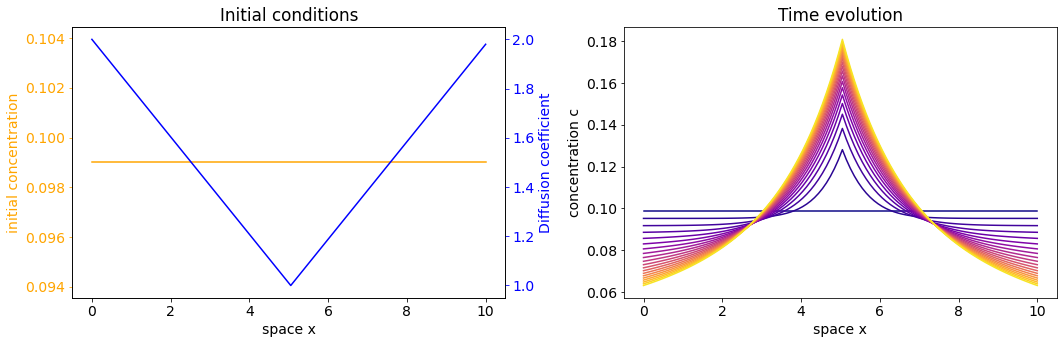

In [7]:
G = dt/dx**2

def CreateDarray(x,Nx):
    D0 = 1
    D1 = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = (D0-D1)/int(Nx/2)*i+D1
        ini[i+int(Nx/2)] = -(D0-D1)/int(Nx/2)*i+D0
    return ini#
Darray = CreateDarray(x,Nx)

M = np.zeros((Nx,Nx))
for i in range(1,Nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1
M[0,1] = M[-1,-2] = 0
#print(M)

c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = np.ones(Nx)/(sum(np.ones(Nx))*dx)#binitial#

for i in range(1,Nt):
    b = c[:,i-1]
    #b[0] = b[-1] = 0
    csingle = np.linalg.solve(M,b)
    c[:,i] = csingle/sum(abs(csingle)*dx)
    
plotresult(x,c,Darray,'Explicit Solution with D(x)')

### Use Neumann boundary conditions instead
https://math.stackexchange.com/questions/2706701/neumann-boundary-conditions-in-finite-difference

Here the condition is, that the derivative at the boundary equals a certain value

### $\frac{\mathrm{d}  u_{0}^{n}}{\mathrm{d} x} = A;\; \;  \; \; \; \; \frac{\mathrm{d}  u_{N_{x}}^{n}}{\mathrm{d} x} = B$

or in our case:

### $\frac{u_{1}^{n}-u_{0}^{n}}{\Delta x}=A; \; \; \; \; \; \; \frac{u_{N_{x}}^{n}-u_{N_{x}-1}^{n}}{\Delta x}=B.$

Which is equivalent to:

### $u_{0}^{n}-u_{1}^{n}=-A\Delta x; \; \; \; \; \; \; u_{N_{x}}^{n}-u_{N_{x}-1}^{n}=B\Delta x$

The final matrix to solve is for example in the case $ 6 \times 6$ than:

####  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right )  & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0 & 0\\
 0 & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0\\
 0 & 0  & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0\\
 0 & 0  & 0  &  -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right )\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
-A \Delta x\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
B \Delta x
\end{bmatrix}
$

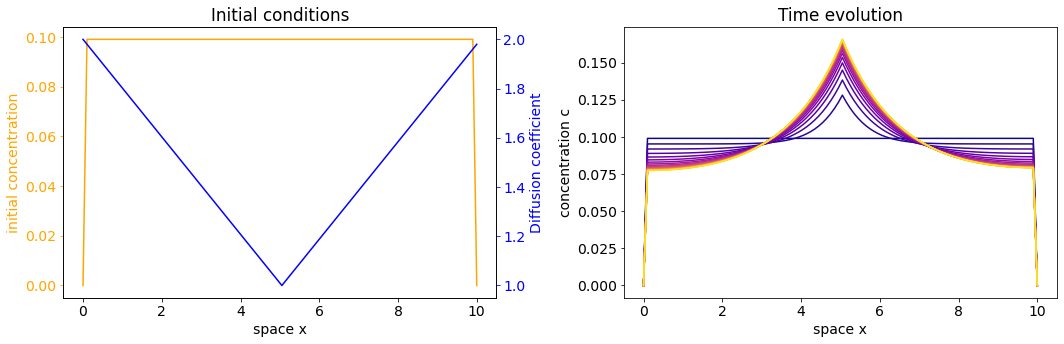

In [10]:
G = dt/dx**2

def CreateDarray(x,Nx):
    D0 = 1
    D1 = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = (D0-D1)/int(Nx/2)*i+D1
        ini[i+int(Nx/2)] = -(D0-D1)/int(Nx/2)*i+D0
    return ini#
Darray = CreateDarray(x,Nx)

M = np.zeros((Nx,Nx))
for i in range(1,Nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1]  #this line looks wrong, but its correct 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = np.ones(Nx)/(sum(np.ones(Nx))*dx)#binitial#

for i in range(1,Nt):
    b = c[:,i-1]
    b[0] = 0
    b[-1] = 0#b[1]
    csingle = np.linalg.solve(M,b)
    c[:,i] = csingle/sum(abs(csingle)*dx)
    
plotresult(x,c,Darray,'Explicit Solution with D(x)')

# Explicit solution

My idea to solve this equation is to transfer it to the following form:

### $\left [ D_{t}^{+}u=D_{x}^{-}\alpha D_{x}^{+}u \right ]^{n}_{i}$

Performe the first forward derivative on $u$ on the right side (and also the backward derivative in time on the left side):

### $\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t} = D^{-}_{x}\alpha  \frac{u_{i+1}^{n}-u_{i}^{n}}{\Delta x}$.

Next step is to performe the first backward derivative on $\alpha$ and the first derivative of $u$. I use the product rule:

### $\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t} = \frac{\alpha_{i}-\alpha _{i-1}}{\Delta x}\cdot \frac{u_{i+1}^{n}-u^{n}_{i}}{\Delta x} + \alpha _{i}\cdot \frac{u^{n}_{i+1}-2u^{n}_{i}+u_{i-1}^{n}}{\Delta x^{2}}$

Rearrange for $u_{i}^{n+1}$:
### $u_{i}^{n+1}=u_{i}^{n}+G\left ( \alpha _{i}u_{i+1}^{n}-\alpha _{i}u_{i}^{n}-\alpha _{i-1}u_{i+1}^{n}+\alpha _{i-1}u_{i}^{n}+\alpha _{i}u^{n}_{i+1}-2\alpha_{i}u_{i}^{n}+\alpha _{i}u_{i-1}^{n} \right )$

Simplify:
### $u_{i}^{n+1}= u_{i}^{n} \left [ 1+G\left ( \alpha _{i-1}-3\alpha _{i} \right ) \right ]  + u_{i-1}^{n}G\alpha _{i}
+u^{n}_{i+1}G\left ( 2\alpha _{i} - \alpha _{i-1} \right ).
$

### This solution does not work!!!! So i tried to solve it with:

### $\left [ D_{t}^{+}u=D_{x}^{+}\alpha D_{x}^{-}u \right ]^{n}_{i}$

The result is here:

### $u_{i}^{n+1}= u_{i}^{n} \left [ 1+G\left ( \alpha _{i+1}-3\alpha _{i} \right ) \right ]  + u_{i-1}^{n}G\left ( 2\alpha _{i} - \alpha _{i+1} \right ) +u^{n}_{i+1}G\alpha _{i}.$

### This also does not work!

In [ ]:
c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = binitial

G = dt/dx**2
#Darray = D*np.ones(Nx)
Darray[:] = CreateDarray(x,Nx)

for n in range(Nt-1):
    for i in range(1,Nx-1):
        #c[i,n+1] = c[i,n]*(1+G*(Darray[i-1]-3*Darray[i])) + c[i-1,n]*G*Darray[i] + c[i+1,n]*G*(2*Darray[i]-Darray[i-1])
        c[i,n+1] = c[i,n]*(1+G*(Darray[i+1]-3*Darray[i])) + c[i-1,n]*G*(2*Darray[i]-Darray[i+1]) + c[i+1,n]*G*Darray[i]
    c[0,n+1] =  c[0,0]#c[1,n+1]#
    c[-1,n+1] =  c[-1,0]#c[-2,n+1]#
    
plotresult(x,c,Darray,'Explicit Solution')

## Test to solve it implicit without t-dependency

### $
0=  \frac{\partial }{\partial x} \left (\alpha \left ( x \right ) \frac{\partial u}{\partial x}   \right )
$

My idea to solve this equation is to transfer it to the following form:

### $\left [ 0 = D_{x}^{-}\alpha D_{x}^{+}u \right ]_{i}$

Performe the first forward derivative on $u$ on the right side (and also the backward derivative in time on the left side):

### $0 = D^{-}\alpha  \frac{u_{i+1}-u_{i}}{\Delta x}$.

Next step is to performe the first backward derivative on $\alpha$ and the first derivative of $u$. I use thte procut rule ($h\left ( x \right ) = f\left ( x \right ) \cdot g\left ( x \right )$; ${h}'\left ( x \right ) = {f}'\left ( x \right ) \cdot g\left ( x \right ) + f\left ( x \right ) \cdot {g}'\left ( x \right )$):

### $0 = \frac{\alpha_{i}-\alpha _{i-1}}{\Delta x}\cdot \frac{u_{i+1}-u_{i}}{\Delta x} + \alpha _{i}\cdot \frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^{2}}$

$\Delta x^{2}$ can be cancelled. Simplify:
### $0= \alpha _{i}u_{i+1}-\alpha _{i}u_{i}-\alpha _{i-1}u_{i+1}+\alpha _{i-1}u_{i}+\alpha _{i}u_{i+1}-2\alpha_{i}u_{i}+\alpha _{i}u_{i-1}$

Collect $u_{i+1}$ terms on the left side:

### $u_{i+1}\left ( -\alpha _{i}+\alpha _{i-1}-\alpha _{i} \right ) = u_{i}\left ( -\alpha _{i}+\alpha _{i-1}-2\alpha _{i} \right ) + u_{i-1}\alpha _{i}$

Rearrange for $u_{i+1}$:

### $u_{i+1} = \frac{u_{i}\left ( \alpha _{i-1}-3\alpha _{i} \right ) + u_{i-1}\alpha _{i}}{
\alpha _{i-1}-2\alpha _{i} }
$

In [ ]:
    c = np.zeros((Nx,2))        #array to save the density distributions
    c[:,0] = c[:,1] = np.ones(Nx)/(sum(np.ones(Nx))*dx)#np.ones(Nx)#binitial

    #Darray = D*np.ones(Nx)
    Darray[:] = CreateDarray(x,Nx)

    for i in range(1,Nx-1):
        c[i+1,1] = (c[i,1]*(Darray[i-1]-3*Darray[i])+c[i-1,1]*Darray[i]) / (Darray[i-1]-2*Darray[i])
    #c[:,1] /= (sum(c[:,1])*dx)
    
    fig=plt.figure(1, figsize = (15,5) )
    host = plt.subplot(1,2,1)
    par1 = host.twinx()
    color1 = 'orange'
    color2 = 'blue'
    host.set_xlabel('space x')
    host.set_ylabel('initial concentration', color=color1)
    par1.set_ylabel('Diffusion coefficient', color=color2)
    host.tick_params('y', colors=color1)
    par1.tick_params('y', colors=color2)
    p1 = host.plot(x,c[:,0],color=color1)
    p2 = par1.plot(x,Darray,color=color2)
    plt.title('Initial conditions')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(x,c[:,:])
    plt.xlabel('space x')
    plt.ylabel('concentration c')
    #plt.title(str(title))
    plt.title('Solution')
    plt.tight_layout()  
    plt.savefig('Result.svg', format='svg')
    plt.show()